In [ ]:
import sys
sys.path.append('..')
import pandas as pd
import matplotlib.pyplot as plt
import foodcosts.core as core
import datetime

In [ ]:
start_date = '2022-01-01'
end_date = '2023-02-19'

In [ ]:
def to_series(values):
    return pd.Series([row[1] for row in values], index = pd.DatetimeIndex([row[0] for row in values]))

In [ ]:
def get_sales_from_so_period_for_shop(start_date, end_date, shop = ''):
    query = """
    SELECT
       v_shop.name AS shop_name, 
       DATE(v_pos_order.created_at) AS day, 
       SUM(pol.price_unit * v_pos_order_line.quantity) AS total_sales
    FROM v_pos_order_line
    LEFT JOIN pos_order_line as pol on pol.id = v_pos_order_line.id
    LEFT JOIN v_product ON v_product.id = v_pos_order_line.product_id
    LEFT JOIN v_pos_order ON v_pos_order.id = v_pos_order_line.order_id
    LEFT JOIN v_pos_session ON v_pos_session.id = v_pos_order.session_id
    LEFT JOIN v_pos ON v_pos.id = v_pos_session.pos_id
    LEFT JOIN v_shop ON v_shop.id = v_pos.shop_id
    WHERE v_pos_order.created_at BETWEEN '{}' AND '{}'
    """.format(start_date, end_date)
    
    if shop != '':
        query += f"""AND v_shop.name = '{shop}'"""
    
    query += "GROUP BY v_shop.id, v_shop.name, day"
    
    return sorted(
        [[row[1], row[2]] for row in core.make_sql_query(query)],
        key=lambda x: x[0]
    )

def get_sales_from_so_period_for_re(start_date, end_date, re_restaurant = ''):
    query = """
    SELECT
       v_resto_entreprise.name AS re_name, 
       DATE(v_pos_order.created_at) AS day, 
       SUM(pol.price_unit * v_pos_order_line.quantity) AS total_sales
    FROM v_pos_order_line
    LEFT JOIN pos_order_line as pol on pol.id = v_pos_order_line.id
    LEFT JOIN v_product ON v_product.id = v_pos_order_line.product_id
    LEFT JOIN v_pos_order ON v_pos_order.id = v_pos_order_line.order_id
    LEFT JOIN v_pos_session ON v_pos_session.id = v_pos_order.session_id
    LEFT JOIN v_pos ON v_pos.id = v_pos_session.pos_id
    LEFT JOIN v_resto_entreprise ON v_resto_entreprise.id = v_pos.shop_id
    WHERE v_pos_order.created_at BETWEEN '{}' AND '{}'
    """.format(start_date, end_date)
    
    if re_restaurant != '':
        query += f"""AND v_resto_entreprise.name = '{re_restaurant}'"""
    
    query += "GROUP BY v_resto_entreprise.id, v_resto_entreprise.name, day"
    
    return sorted(
        [[row[1], row[2]] for row in core.make_sql_query(query)],
        key=lambda x: x[0]
    )

In [ ]:
def get_supplier_food_costs_period_for_shop(start_date, end_date, shop = ''):
    query = """
  SELECT
    to_char(v_purchase_order.order_date, 'YYYY-MM-DD'),
    sum(total_incl_vat) from v_purchase_order
  LEFT JOIN v_supplier on v_supplier.id = v_purchase_order.supplier_id
  LEFT JOIN v_shop on v_shop.id = v_purchase_order.shop_id
  WHERE 
      v_purchase_order.order_date between '{}' and '{}' 
    """.format(start_date, end_date)
    
    if shop != '':
        query += "AND v_shop.name = ('{}')".format(shop)
    
    query += "GROUP BY v_shop.name, to_char(v_purchase_order.order_date, 'YYYY-MM-DD')"                                                
                          
    return sorted(
        [[datetime.datetime.strptime(row[0], '%Y-%m-%d'), row[1]] for row in core.make_sql_query(query)],
        key=lambda x: x[0]
    )

def get_supplier_food_costs_period_for_re(start_date, end_date, re_restaurant = ''):
    query = """
  SELECT
    to_char(v_purchase_order.order_date, 'YYYY-MM-DD'),
    sum(total_incl_vat) from v_purchase_order
  LEFT JOIN v_supplier on v_supplier.id = v_purchase_order.supplier_id
  LEFT JOIN v_resto_entreprise on v_resto_entreprise.id = v_purchase_order.shop_id
  WHERE 
      v_purchase_order.order_date between '{}' and '{}' 
    """.format(start_date, end_date)
    
    if re_restaurant != '':
        query += "AND v_resto_entreprise.name = ('{}')".format(re_restaurant)
    
    query += "GROUP BY v_resto_entreprise.name, to_char(v_purchase_order.order_date, 'YYYY-MM-DD')"                                                
                          
    return sorted(
        [[datetime.datetime.strptime(row[0], '%Y-%m-%d'), row[1]] for row in core.make_sql_query(query)],
        key=lambda x: x[0]
    )


In [ ]:
def get_atelier_food_costs_period_for_shop(start_date, end_date, shop = ''):
    query = """
select 
    shop.id as shop_id,
    shop.name as shop_name,
    stats.day as date,
    sum(stats.discounted_atelier_value_sent_htva) as discounted_atelier_value_sent_htva
from v_shop_sales_statistics as stats 
left join v_shop as shop on shop.id = stats.shop_id
left join pos_order_stat_day on pos_order_stat_day.day = stats.day and (pos_order_stat_day.interval <> 'month')
where stats.day between '{}' and '{}' and discounted_atelier_value_sent_htva < 10000
    """.format(start_date, end_date)
    
    
    if shop != '':
        query += f"""AND shop.name = '{shop}'"""
    
    query += "group by shop.id, shop.name, stats.day"                                                
                              
    return sorted(
        [[row[2], row[3]] for row in core.make_sql_query(query)],
        key=lambda x: x[0]
    )

def get_atelier_food_costs_period_for_re(start_date, end_date, re_restaurant = ''):
    query = """
select 
    re_restaurant.id as re_restaurant_id,
    re_restaurant.name as re_restaurant_name,
    stats.day as date,
    sum(stats.discounted_atelier_value_sent_htva) as discounted_atelier_value_sent_htva
from v_shop_sales_statistics as stats 
left join v_resto_entreprise as re_restaurant on re_restaurant.id = stats.shop_id
left join pos_order_stat_day on pos_order_stat_day.day = stats.day and (pos_order_stat_day.interval <> 'month')
where stats.day between '{}' and '{}' and discounted_atelier_value_sent_htva < 10000
    """.format(start_date, end_date)
    
    
    if re_restaurant != '':
        query += f"""AND re_restaurant.name = '{re_restaurant}'"""
    
    query += "group by re_restaurant.id, re_restaurant.name, stats.day"                                                
                              
    return sorted(
        [[row[2], row[3]] for row in core.make_sql_query(query)],
        key=lambda x: x[0]
    )

In [ ]:
def get_date_range(start_date, end_date):
    # convert the input strings to datetime objects
    start_dt = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = datetime.datetime.strptime(end_date, '%Y-%m-%d')

    # calculate the number of days between start and end, inclusive
    num_days = (end_dt - start_dt).days + 1

    # use a list comprehension to generate a list of date objects
    dates = [start_dt.date() + datetime.timedelta(days=i) for i in range(num_days)]

    return dates

In [ ]:
def get_food_costs_period(start_date, end_date, shop = '', re_restaurant=''):
    if shop != '':
        atelier = get_atelier_food_costs_period_for_shop(start_date, end_date, shop=shop)
    if re_restaurant != '':
        atelier = get_atelier_food_costs_period_for_re(start_date,end_date, re_restaurant=re_restaurant)
    
    atelier_dict = { date: amount for date,amount in atelier }
    
    if shop != '':
        supplier = get_supplier_food_costs_period_for_shop(start_date, end_date, shop=shop)
    if re_restaurant != '':
        supplier = get_supplier_food_costs_period_for_re(start_date, end_date, re_restaurant=re_restaurant)
    
    supplier_dict = { date.date(): amount for date,amount in supplier }
    date_range = get_date_range(start_date,end_date)
    res = []
    atelier_totals = []
    supplier_totals = []
    for date in date_range:
        
        atelier_for_date = atelier_dict[date] if date in atelier_dict else 0
        supplier_for_date = supplier_dict[date] if date in supplier_dict else 0
        
        atelier_totals.append([date, atelier_for_date])
        supplier_totals.append([date, supplier_for_date])        
        
        res.append([date, 
                    (atelier_for_date if atelier_for_date != None else 0) + 
                    (supplier_for_date if not supplier_for_date != None else 0)
                   ])
    return res

In [ ]:
def divide(values_a, values_b):        
    values_b=values_b.replace(0, 1)
    res = values_a.divide(values_b, fill_value=1)
    res = res.astype(float)
    return res

def pct_costs_on_revenues(start_date, end_date, shop = '', re_restaurant='', frequency = 'M'):    
    food_costs_daily = get_food_costs_period(start_date, end_date, shop = shop, re_restaurant = re_restaurant)
    
    if shop != '':
        sales_from_so_daily = get_sales_from_so_period_for_shop(start_date, end_date, shop = shop)
    if re_restaurant != '':    
        sales_from_so_daily = get_sales_from_so_period_for_re(start_date, end_date, re_restaurant = re_restaurant)
        
    num = to_series(food_costs_daily).resample(frequency).sum()
    denum = to_series(sales_from_so_daily).resample(frequency).sum()
    denum = denum.drop(labels=denum[denum == 0].index)
    
    return divide(
        num,
        denum,       
    )

In [ ]:
def get_dict_of_pct_food_costs_on_revenues(shops=[], re_restaurants=[]):
    series_dict = {}
    
    for shop in shops:
        series = pct_costs_on_revenues(start_date, end_date, shop=shop, frequency='M')
        series_dict[shop] = series
    
    for re_restaurant in re_restaurants:
        series = pct_costs_on_revenues(start_date, end_date, re_restaurant=re_restaurant, frequency='M')
        series_dict[re_restaurant] = series
    
    return series_dict;


def plot_pct_food_costs_on_revenues(name, series, avg_of_series):
    series.plot(label=name, color='blue')
    avg_of_series.plot(label= "Average", color='orange')
    
    plt.xlabel('Date')
    plt.ylabel('%')
    plt.legend(loc='best')
    plt.show()

In [ ]:
shops = core.get_shop_names()
unwanted_shops = {'Tongres'}
shops = [shop for shop in shops if shop not in unwanted_shops]

pct_food_costs_on_revenues_for_shops_dict = get_dict_of_pct_food_costs_on_revenues(shops=shops)

config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that


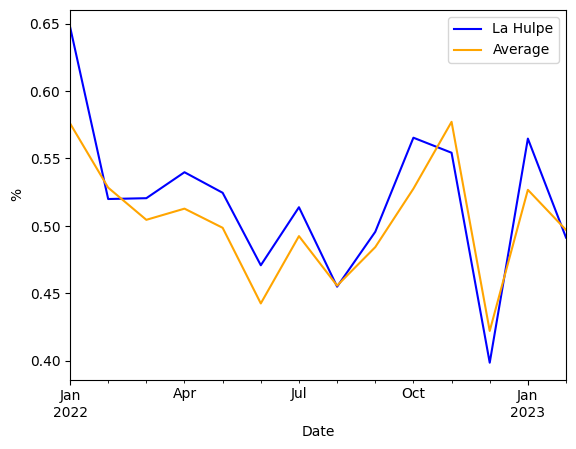

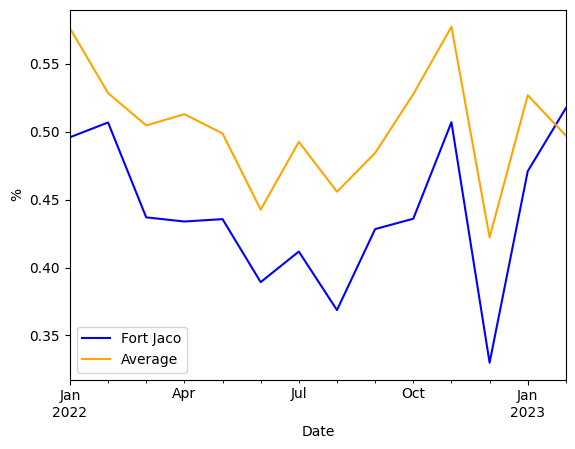

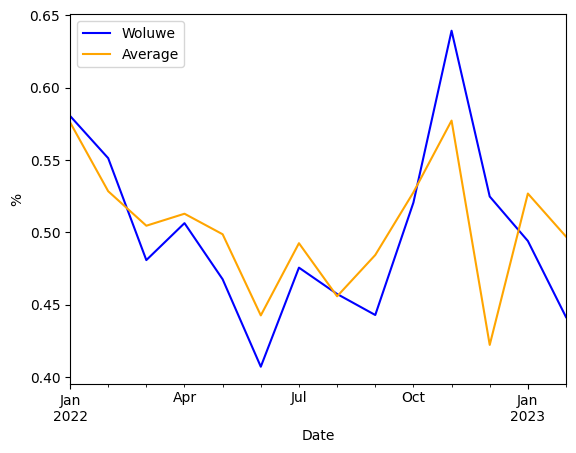

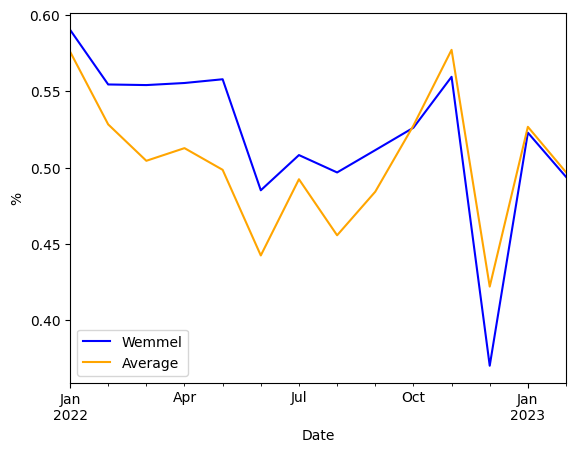

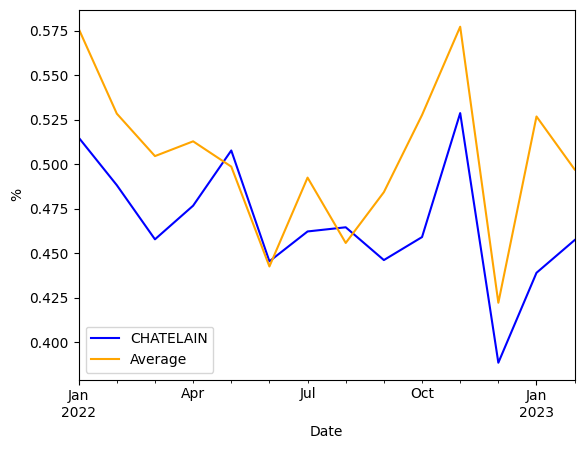

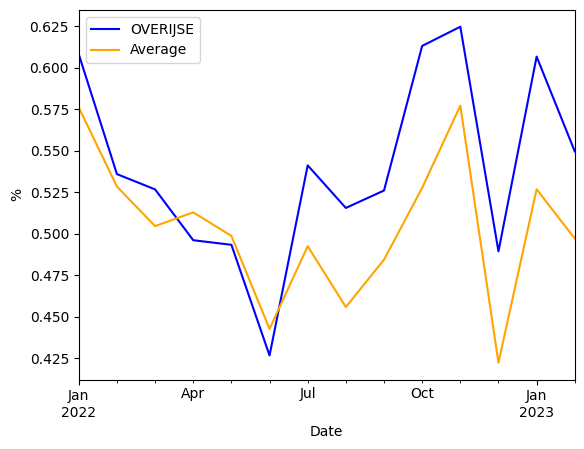

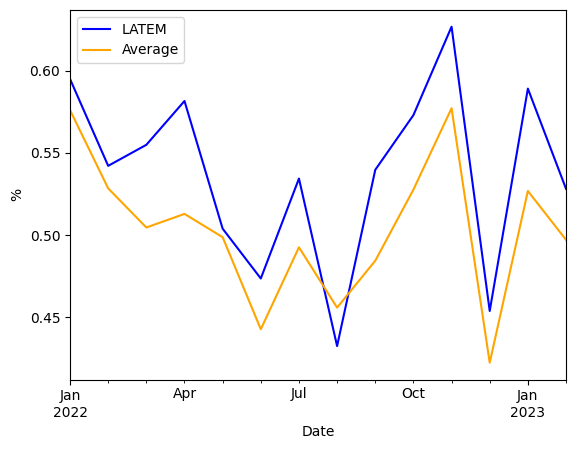

In [ ]:
avg_pct_food_costs_on_revenues_of_shop = sum([pct_food_costs_on_revenues_for_shops_dict[shop] for shop in shops])/len(shops)

for shop in shops:
    plot_pct_food_costs_on_revenues(shop, pct_food_costs_on_revenues_for_shops_dict[shop], avg_pct_food_costs_on_revenues_of_shop)
   

In [ ]:
re_restaurants = [name for (i, name) in core.make_sql_query("select * from v_resto_entreprise")]
unwanted_re_restaurants = {'BOTANIC TOWER', 'R.E EUROCONTROL', 'R.E LIGHTHOUSE'}
re_restaurants = [re_restaurant for re_restaurant in re_restaurants if re_restaurant not in unwanted_re_restaurants]

pct_food_costs_on_revenues_for_re_dict = get_dict_of_pct_food_costs_on_revenues(re_restaurants=re_restaurants)

config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that


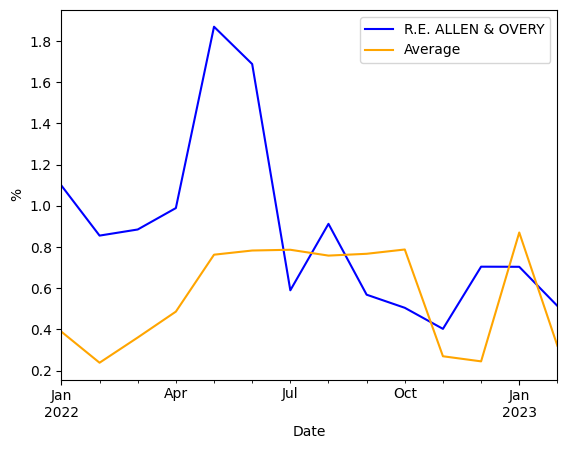

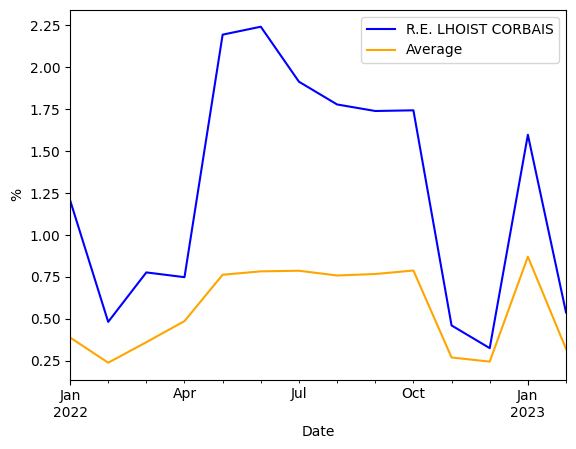

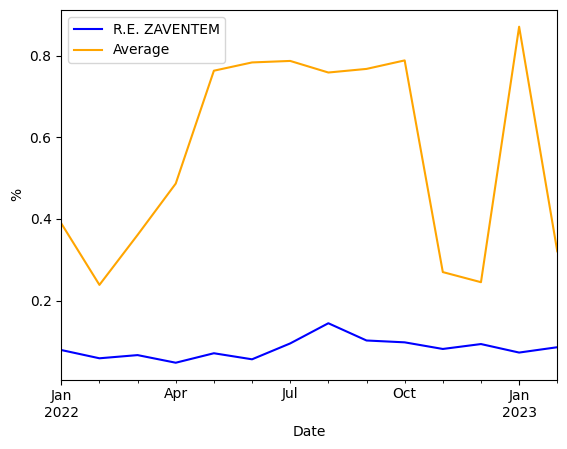

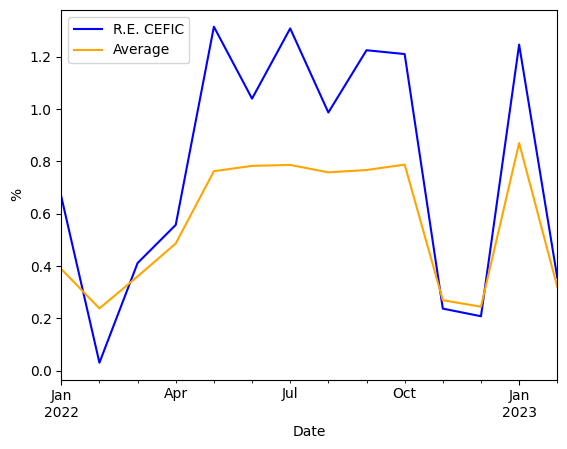

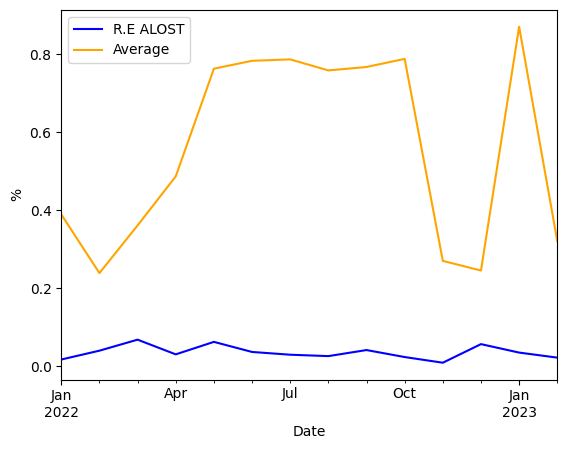

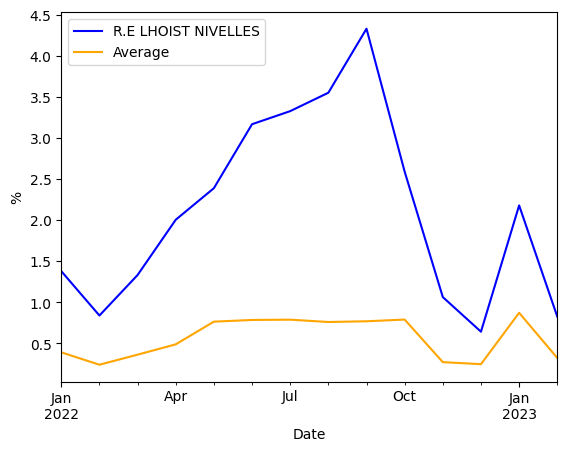

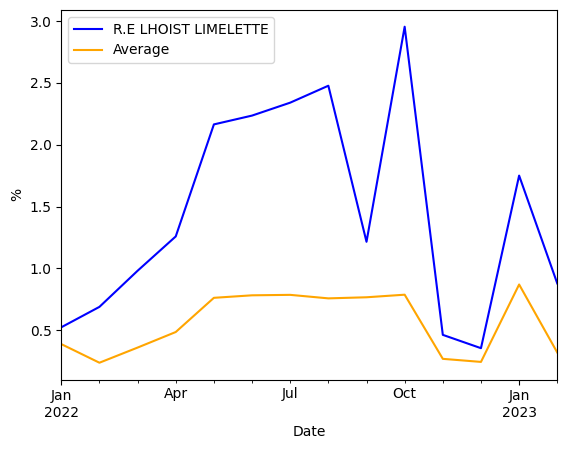

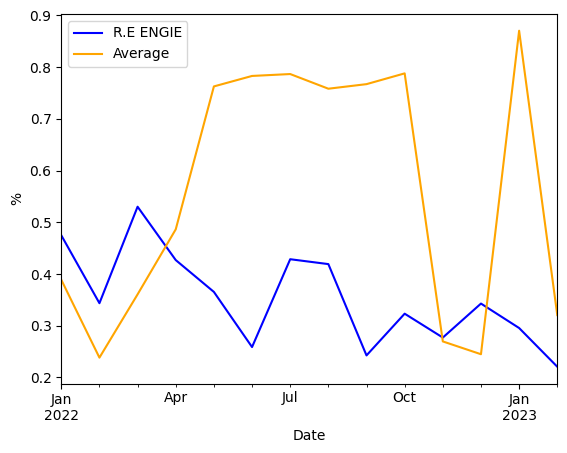

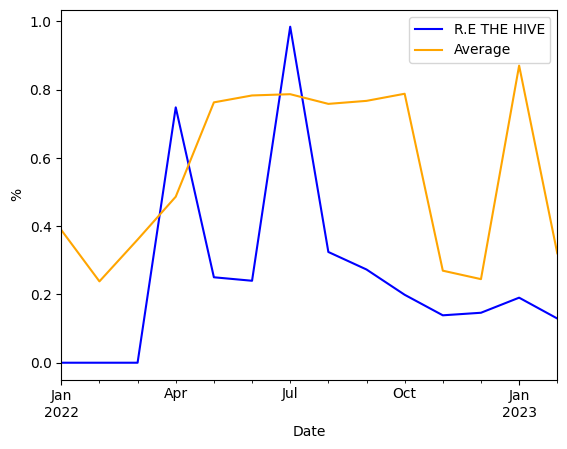

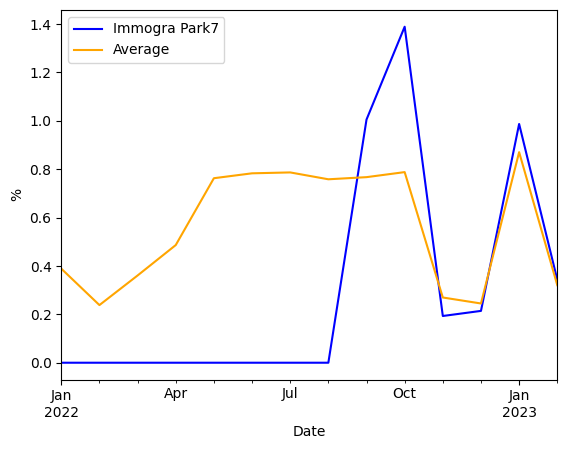

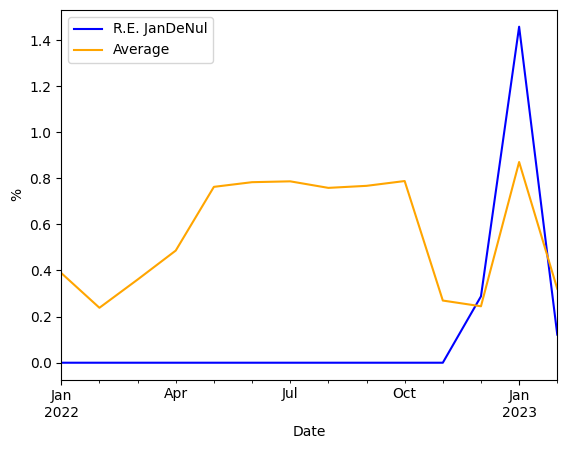

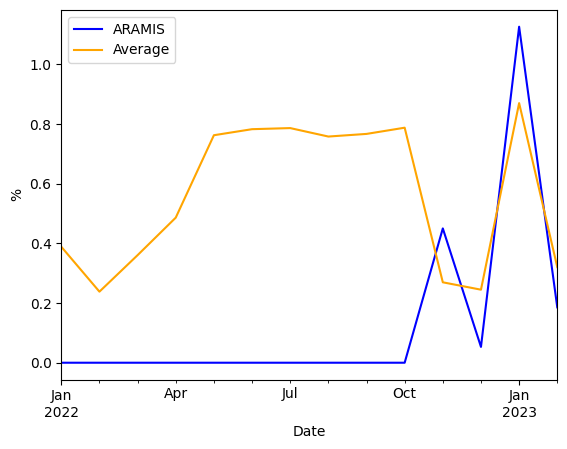

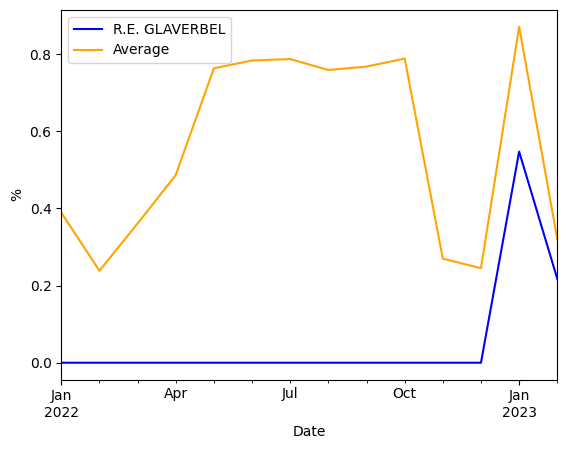

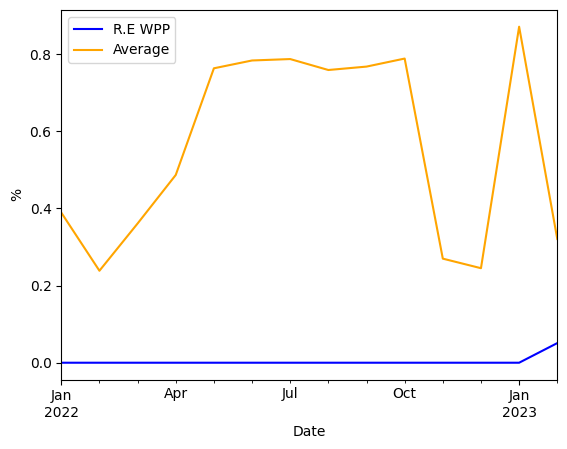

In [ ]:
avg_pct_food_costs_on_revenues_of_re = sum([pct_food_costs_on_revenues_for_re_dict[re_restaurant] for re_restaurant in re_restaurants])/len(re_restaurants)

for re_restaurant in re_restaurants:
    plot_pct_food_costs_on_revenues(re_restaurant, pct_food_costs_on_revenues_for_re_dict[re_restaurant], avg_pct_food_costs_on_revenues_of_re)
   